# Loan Predictor

**Background**

Customer first apply for home loan after that company validates the customer eligibility for loan. Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

**Data**

- `Loan_ID`: Unique Loan ID
- `Gender`: Male/ Female
- `Married`: Applicant married (Y/N)
- `Dependents`: Number of dependents
- `Education`: Applicant Education (Graduate/ Under Graduate)
- `Self_Employed`: Self employed (Y/N)
- `ApplicantIncome`: Applicant income
- `CoapplicantIncome`: Coapplicant income
- `LoanAmount`: Loan amount in thousands
- `Loan_Amount_Term`: Term of loan in months
- `Credit_History`: credit history meets guidelines
- `Property_Area`: Urban/ Semi Urban/ Rural
- `Loan_Status`: Loan approved (Y/N)

**Metrics**

Evaluation metric is accuracy, i.e. percentage of loan approval you correctly predict.

In [249]:
import pandas as pd
import numpy as np
import scipy as sc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Load Data

In [250]:
train = pd.read_csv('loan_train.csv')
test = pd.read_csv('loan_test.csv')

In [251]:
print(train.shape)
train.head()
# response variable is the last column 'Loan_Status'

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


**The train dataset contains 614 observations and 13 features, 12 of which are characteristics of the loan applicant. The last column is our target variable `Loan_Status`.**

In [252]:
print(test.shape)
test.head()

(367, 12)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


**The test dataset contains 367 observations and 12 features because we use more data to accurately train our classification model to predict on the missing target vector `Loan_Status`.**

In [253]:
train.columns = [x.lower() for x in train.columns]
test.columns = [x.lower() for x in test.columns]

**By converting all column names to lowercase, calling column names becomes more efficient and easier.**

## Data Cleaning

In [254]:
train.dtypes

loan_id               object
gender                object
married               object
dependents            object
education             object
self_employed         object
applicantincome        int64
coapplicantincome    float64
loanamount           float64
loan_amount_term     float64
credit_history       float64
property_area         object
loan_status           object
dtype: object

In [255]:
train.describe()

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


**From this summary of the numerical variables, we can observe that**

   - **`loanamount`, `loan_amount_term`, and `credit_history` have missing data because their counts are less than 614**

   - **There is more variability in `applicantincome` and `coapplicantincome` than `loanamount` and `loan_amount_term` when comparing their interquartile ranges (Q3-Q1)**

   - **84% of applicants have a credit history because the mean is 0.84 in the range of 0 (no) and 1 (yes)**

   - **By comparing the mean and median, we can have an idea of if and how skewed the data is for each feature**

### Missing data

In [256]:
train.isnull().sum()

loan_id               0
gender               13
married               3
dependents           15
education             0
self_employed        32
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
loan_status           0
dtype: int64

In [178]:
train.columns[train.isnull().any()].tolist()

['gender',
 'married',
 'dependents',
 'self_employed',
 'loanamount',
 'loan_amount_term',
 'credit_history']

**There are missing values in the columns `gender`, `married`, `dependents`, `self_employed`, `loan_amount`, `loam_amount_term`, and `credit_history`.**

In [257]:
print(len(train['loan_id'].unique()))
train = train.drop('loan_id', axis=1)

614


**Because `loan_id` is a unique piece of nominal info such as a student's name that does not have much influence on the loan status, we will drop it.**

In [179]:
# rows that contain one or more na
na_df = train[train.isnull().any(axis=1)]
perc_na = len(na_df)*100/len(train)
print('%d percent of rows in the train set contain one or more NaN values.' % perc_na)

21 percent of rows in the train set contain one or more NaN values.


**Because a significant number of rows contain NaN values, we choose not to drop these rows.**

**Hypothesis: an applicant's education level and self-employment status can serve as good estimates to the loan amount.**

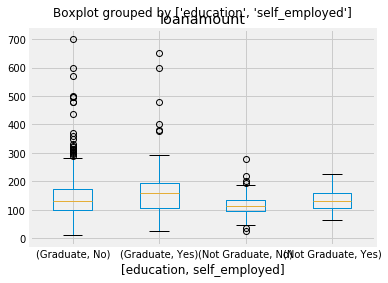

In [180]:
train.boxplot('loanamount', by=['education', 'self_employed'])

In [181]:
train['self_employed'].value_counts()

No     500
Yes     82
Name: self_employed, dtype: int64

**Since ~86% of values are "no", it's safe to impute the missing value as "No".**

In [182]:
train['self_employed'].fillna('No', inplace=True)

#### Method 1: impute the missing values with the median loan amount for all the groups of unique values of self_employed and education features

In [183]:
table = train.pivot_table(values='loanamount', index='self_employed', columns='education', aggfunc=np.median)

# Define function to return value of this pivot_table
def fage(x):
     return table.loc[x['self_employed'], x['education']]

# Replace missing values
train['loanamount'].fillna(train[train['loanamount'].isnull()].apply(fage, axis=1), inplace=True)

table

education,Graduate,Not Graduate
self_employed,,
No,130.0,113.0
Yes,157.5,130.0


#### Method 2: impute the missing values with the mean or mode values of each column irrespective of other columns

In [184]:
fill_mode_columns = ['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term', 'credit_history']
fill_mean_columns = ['loanamount']

for col in fill_mode_columns:
    train[col].fillna(train[col].mode()[0], inplace=True)

for col in fill_mean_columns:
    train[col].fillna(train[col].mean(), inplace=True)

### Extreme data

**`applicantincome` and `loanamount` seem to contain extreme values at either end**

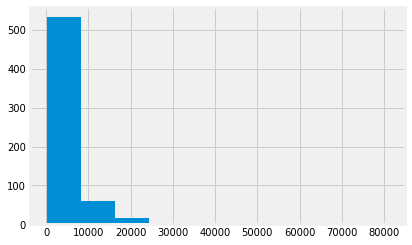

In [185]:
train['applicantincome'].hist()

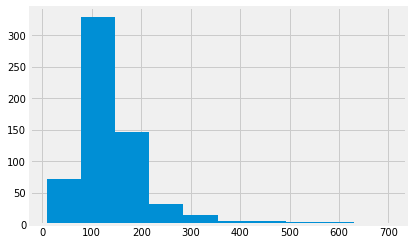

In [186]:
train['loanamount'].hist()

#### Method: apply a log transformation to nullify the effect of extreme values instead of treating them as outliers

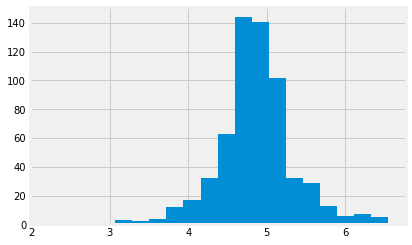

In [187]:
train['loanamount_log'] = np.log(train['loanamount'])
train['loanamount_log'].hist(bins=20)

**The distribution looks much closer to normal and the effect of extreme values has been significantly subsided.**

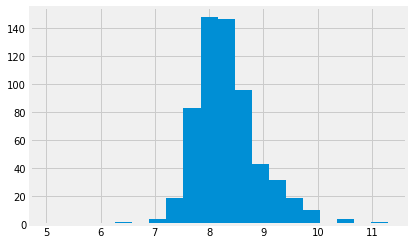

In [188]:
train['applicantincome_log'] = np.log(train['applicantincome'])
train['applicantincome_log'].hist(bins=20)

**An intuition for applicant income may be that some applicants have lower income but strong support coapplicants, so it might be a good idea to combine both incomes and take the log transformation.**

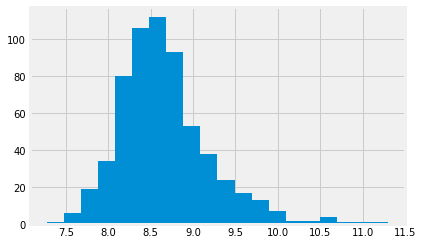

In [189]:
train['totalincome'] = train['applicantincome'] + train['coapplicantincome']
train['totalincome_log'] = np.log(train['totalincome'])
train['totalincome_log'].hist(bins=20)

## Exploratory Data Analysis

,gender,count
0,Female,112
1,Male,502


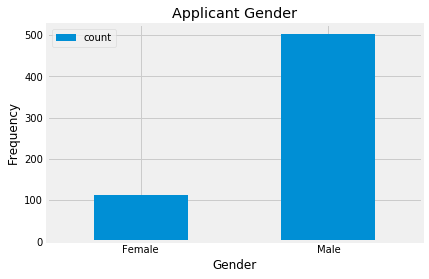

In [190]:
# gender
gender = train.groupby('gender')['gender'].size().reset_index(name='count')
gender.plot.bar('gender')
plt.xticks(rotation=0)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Applicant Gender')
gender

Text(0.5, 1.0, 'Applicant Gender')

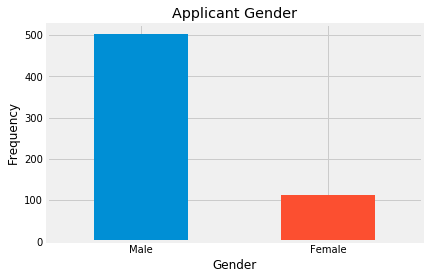

In [191]:
train['gender'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Applicant Gender')

**A majority of loan applicants are male.**

,married,count
0,No,213
1,Yes,401


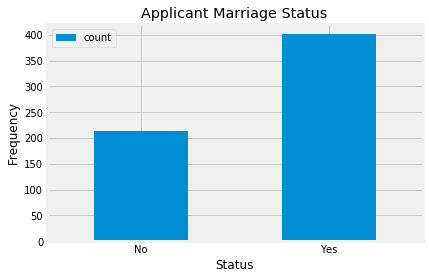

In [192]:
# married
married = train.groupby('married')['married'].size().reset_index(name='count')
married.plot.bar('married')
plt.xticks(rotation=0)
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title('Applicant Marriage Status')
married

Text(0.5, 1.0, 'Applicant Marriage Status')

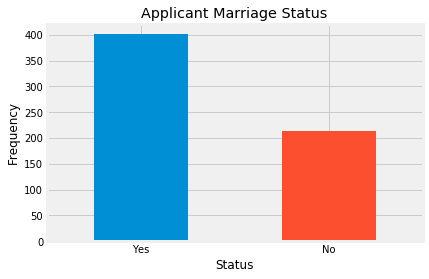

In [193]:
train['married'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title('Applicant Marriage Status')

**Approximately a third of the applicants are not married, while two-thirds are married.**

,dependents,count
0,0,360
1,1,102
2,2,101
3,3+,51


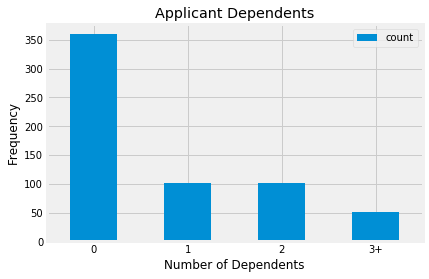

In [194]:
# dependents
dependents = train.groupby('dependents')['dependents'].size().reset_index(name='count')
dependents.plot.bar('dependents')
plt.xticks(rotation=0)
plt.xlabel('Number of Dependents')
plt.ylabel('Frequency')
plt.title('Applicant Dependents')
dependents

Text(0.5, 1.0, 'Applicant Dependents')

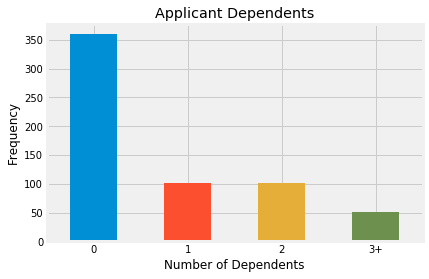

In [195]:
train['dependents'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Number of Dependents')
plt.ylabel('Frequency')
plt.title('Applicant Dependents')

**About 1/12 of the applicants have more than three dependents, 1/6 have 2 dependents, 1/6 have 1 dependent, and 7/12 have no dependents.**

,education,count
0,Graduate,480
1,Not Graduate,134


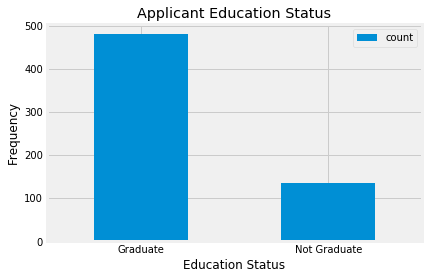

In [196]:
# education
education = train.groupby('education')['education'].size().reset_index(name='count')
education.plot.bar('education')
plt.xticks(rotation=0)
plt.xlabel('Education Status')
plt.ylabel('Frequency')
plt.title('Applicant Education Status')
education

Text(0.5, 1.0, 'Applicant Education Status')

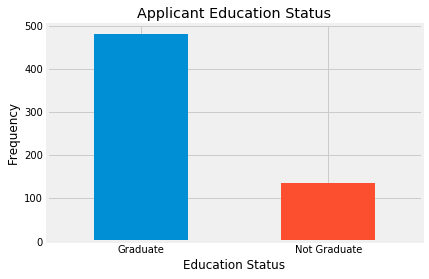

In [197]:
train['education'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Education Status')
plt.ylabel('Frequency')
plt.title('Applicant Education Status')

**About 80% of applicants are graduates.**

,self_employed,count
0,No,532
1,Yes,82


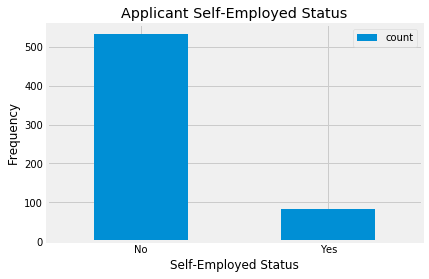

In [198]:
# employment
self_emp = train.groupby('self_employed')['self_employed'].size().reset_index(name='count')
self_emp.plot.bar('self_employed')
plt.xticks(rotation=0)
plt.title('Applicant Self-Employed Status')
plt.xlabel('Self-Employed Status')
plt.ylabel('Frequency')
self_emp

Text(0.5, 1.0, 'Applicant Self-Employed Status')

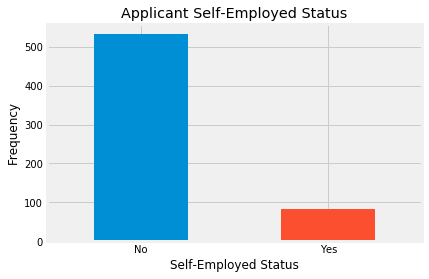

In [199]:
train['self_employed'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Self-Employed Status')
plt.ylabel('Frequency')
plt.title('Applicant Self-Employed Status')

**Over 5/6 of applicants are not self-employed.**

Text(0.5, 1.0, 'Applicant Income')

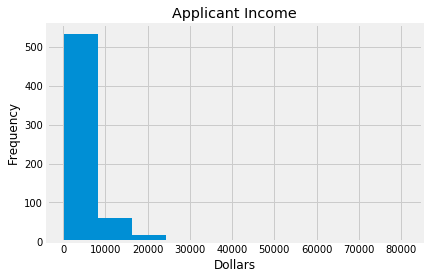

In [200]:
# applicant income
train.hist('applicantincome')
plt.xlabel('Dollars')
plt.ylabel('Frequency')
plt.title('Applicant Income')

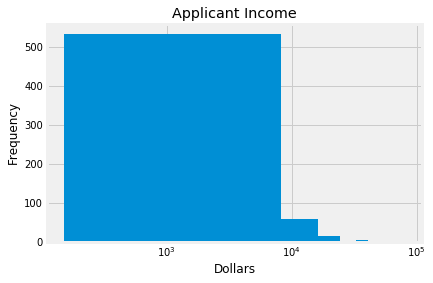

In [201]:
# applicant income with log scale
train.hist('applicantincome')
plt.xlabel('Dollars')
plt.ylabel('Frequency')
plt.title('Applicant Income')
plt.xscale('log')

**Over 80% of applicants have incomes of less than $100k.**

Text(0.5, 1.0, 'Co-Applicant Income')

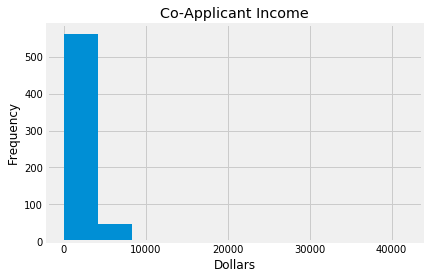

In [202]:
# coapplicant income
train.hist('coapplicantincome')
plt.xlabel('Dollars')
plt.ylabel('Frequency')
plt.title('Co-Applicant Income')

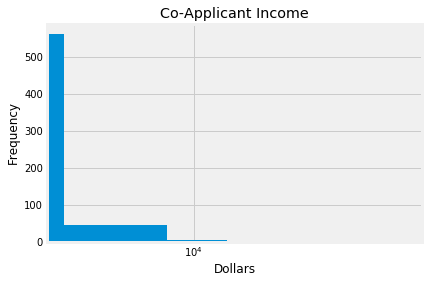

In [203]:
# coapplicant income with log scale
train.hist('coapplicantincome')
plt.xlabel('Dollars')
plt.ylabel('Frequency')
plt.title('Co-Applicant Income')
plt.xscale('log')

**About 90% of coapplicants have incomes of less than $50,000.**

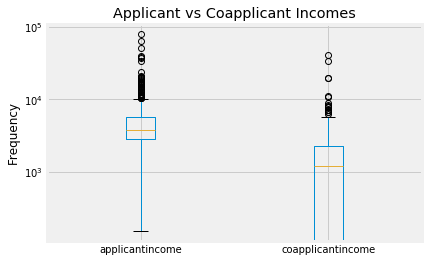

In [204]:
train[['applicantincome', 'coapplicantincome']].plot.box()
plt.ylabel('Frequency')
plt.title('Applicant vs Coapplicant Incomes')
plt.yscale('log')

Text(0.5, 1.0, 'Applicant Loan Amount')

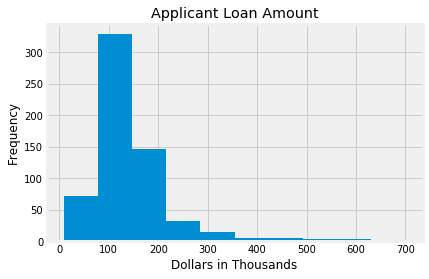

In [205]:
# loan amount in thousands
train.hist('loanamount')
plt.xlabel('Dollars in Thousands')
plt.ylabel('Frequency')
plt.title('Applicant Loan Amount')

Text(0.5, 1.0, 'Applicant Loan Amount')

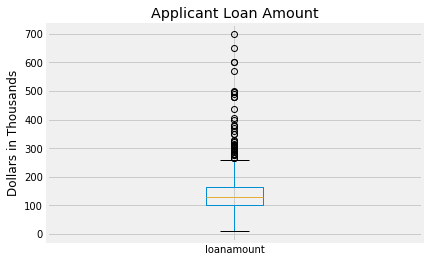

In [206]:
train['loanamount'].plot.box()
plt.ylabel('Dollars in Thousands')
plt.title('Applicant Loan Amount')

**A majority of applicants apply for loan of amounts between a few thousands of dollars to $300k.**

Text(0.5, 1.0, 'Applicant Term of Loan Amount')

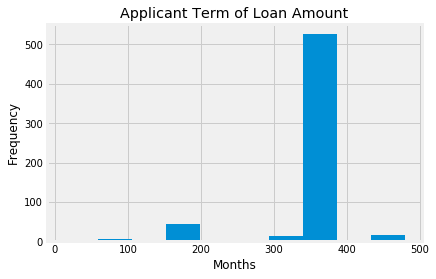

In [207]:
# loan amount term in months
train.hist('loan_amount_term')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Applicant Term of Loan Amount')

Text(0.5, 1.0, 'Applicant Term of Loan Amount')

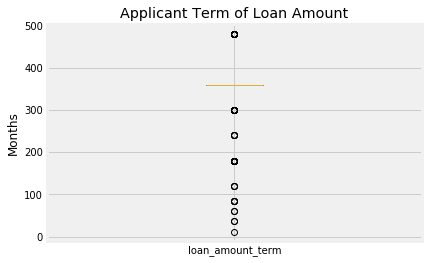

In [208]:
train['loan_amount_term'].plot.box()
plt.ylabel('Months')
plt.title('Applicant Term of Loan Amount')

**Almost all of the terms of loans last 360 months or 30 years with the exception of several outliers.**

,credit_history,count
0,0.0,89
1,1.0,525


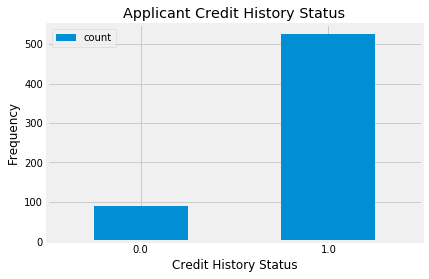

In [209]:
# credit history
cred_history = train.groupby('credit_history')['credit_history'].size().reset_index(name='count')
cred_history.plot.bar('credit_history')
plt.xticks(rotation=0)
plt.xlabel('Credit History Status')
plt.ylabel('Frequency')
plt.title('Applicant Credit History Status')
cred_history

Text(0.5, 1.0, 'Applicant Credit History Status')

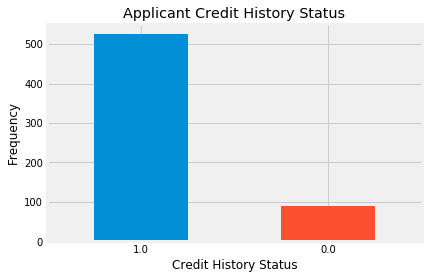

In [210]:
train['credit_history'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Credit History Status')
plt.ylabel('Frequency')
plt.title('Applicant Credit History Status')

**Over 80% of applicants have credit histories that meet the guidelines.**

,property_area,count
0,Rural,179
1,Semiurban,233
2,Urban,202


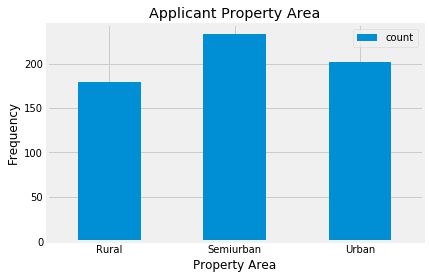

In [211]:
# property area
prop_area = train.groupby('property_area')['property_area'].size().reset_index(name='count')
prop_area.plot.bar('property_area')
plt.xticks(rotation=0)
plt.xlabel('Property Area')
plt.ylabel('Frequency')
plt.title('Applicant Property Area')
prop_area

Text(0.5, 1.0, 'Applicant Property Area')

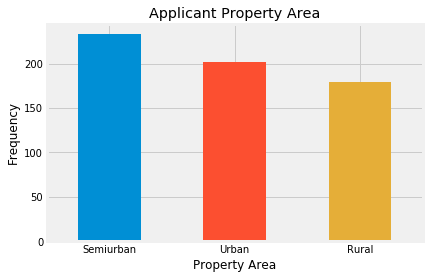

In [212]:
train['property_area'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Property Area')
plt.ylabel('Frequency')
plt.title('Applicant Property Area')

**The amount of applicants distributed across the three property areas are almost roughly equal, with the most located in semiurban areas and the least located in rural areas.**

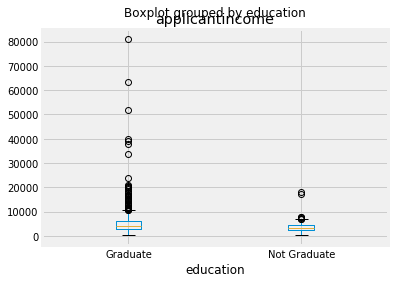

In [213]:
train.boxplot(column='applicantincome', by='education')

**There is no substantial difference between the mean income of graduate and non-graduates, but there are high number of graduates with very high incomes shown as outliers.**

### Categorical Variable Analysis

In [214]:
# create a pivot table to look at chances of getting a loan based on
# credit history
cred1 = train['credit_history'].value_counts(ascending=True)
cred2 = train.pivot_table(values='loan_status', index=['credit_history'], aggfunc=lambda x: x.map({'Y':1, 'N':0}).mean())
print ('Frequency Table for Credit History:') 
print (cred1)

print ('\nProbability of getting loan for each Credit History class:')
print (cred2)

Frequency Table for Credit History:
0.0     89
1.0    525
Name: credit_history, dtype: int64

Probability of getting loan for each Credit History class:
                loan_status
credit_history             
0.0                0.078652
1.0                0.790476


Text(0.5, 1.0, 'Probability of Getting Loan by Credit History')

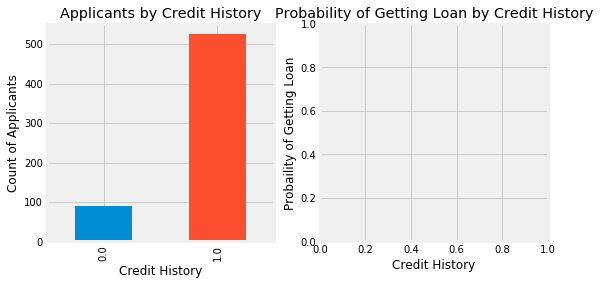

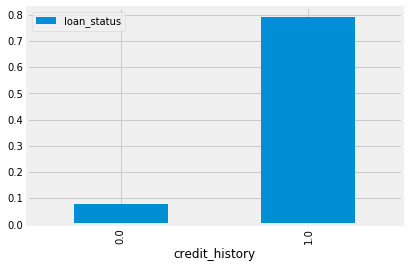

In [215]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Credit History')
cred1.plot(kind='bar')

ax2 = fig.add_subplot(122)
cred2.plot(kind='bar')
ax2.set_xlabel('Credit History')
ax2.set_ylabel('Probaility of Getting Loan')
ax2.set_title('Probability of Getting Loan by Credit History')

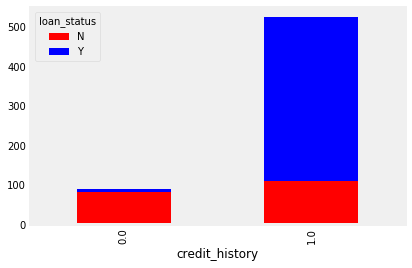

In [216]:
cred3 = pd.crosstab(train['credit_history'], train['loan_status'])
cred3.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)

In [217]:
married1 = train['married'].value_counts(ascending=True)
married2 = train.pivot_table(values='loan_status', index='married', 
                             aggfunc=lambda x: x.map({'Y': 1, 'N':0}).mean())

print('Frequency Table for Marriage Status')
print(married1)

print('\nProbability of Getting Loan for Each Marriage Status Class:')
print(married2)

Frequency Table for Marriage Status
No     213
Yes    401
Name: married, dtype: int64

Probability of Getting Loan for Each Marriage Status Class:
         loan_status
married             
No          0.629108
Yes         0.718204


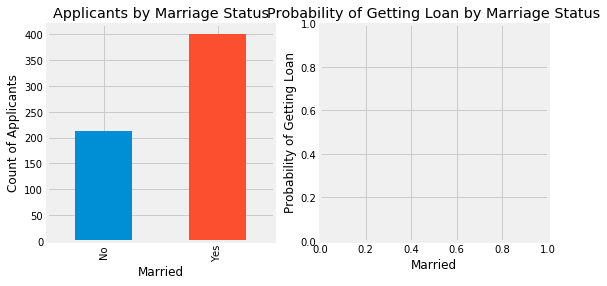

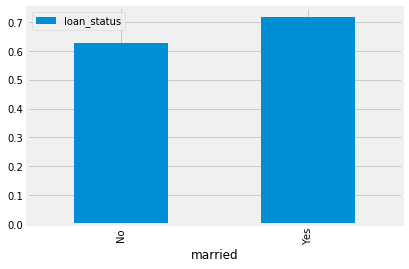

In [218]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Married')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Marriage Status')
married1.plot(kind='bar')

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Married')
ax2.set_ylabel('Probability of Getting Loan')
ax2.set_title('Probability of Getting Loan by Marriage Status')
married2.plot(kind='bar')

In [219]:
selfemp1 = train['self_employed'].value_counts(ascending=True)
selfemp2 = train.pivot_table(values='loan_status', index=['self_employed'],
                             aggfunc=lambda x: x.map({'Y': 1, 'N': 0}).mean())

print('Frequency Table for Self-Employed')
print(selfemp1)

print('\nProbability of Getting Loan for Each Self-Employed Class:')
print(selfemp2)

Frequency Table for Self-Employed
Yes     82
No     532
Name: self_employed, dtype: int64

Probability of Getting Loan for Each Self-Employed Class:
               loan_status
self_employed             
No                0.687970
Yes               0.682927


Text(0.5, 1.0, 'Probability of Getting Loan by Self-Employed')

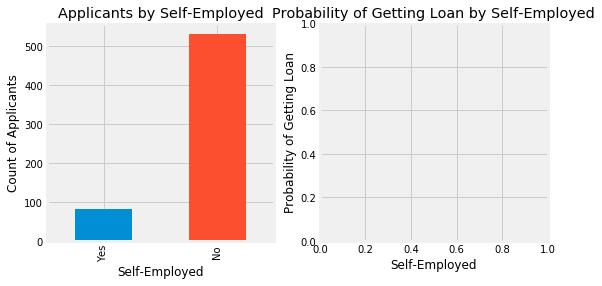

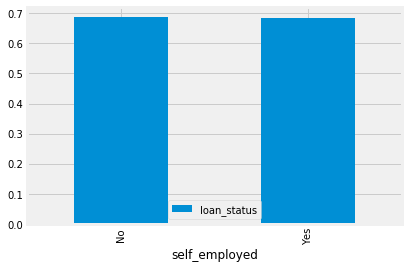

In [220]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Self-Employed')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Self-Employed')
selfemp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
selfemp2.plot(kind='bar')
ax2.set_xlabel('Self-Employed')
ax2.set_ylabel('Probability of Getting Loan')
ax2.set_title('Probability of Getting Loan by Self-Employed')

In [221]:
proparea1 = train['property_area'].value_counts(ascending=True)
proparea2 = train.pivot_table(values='loan_status',index=['property_area'],
                              aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print ('Frequency Table for Property Area:') 
print (proparea1)

print ('\nProbability of Getting Loan for Each Property Area Class:')
print (proparea2)

Frequency Table for Property Area:
Rural        179
Urban        202
Semiurban    233
Name: property_area, dtype: int64

Probability of Getting Loan for Each Property Area Class:
               loan_status
property_area             
Rural             0.614525
Semiurban         0.768240
Urban             0.658416


Text(0.5, 1.0, 'Probability of Getting Loan by Property Area')

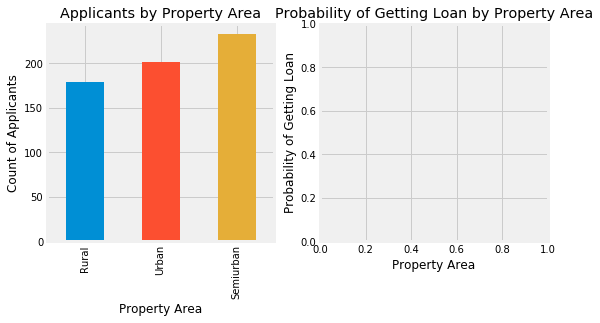

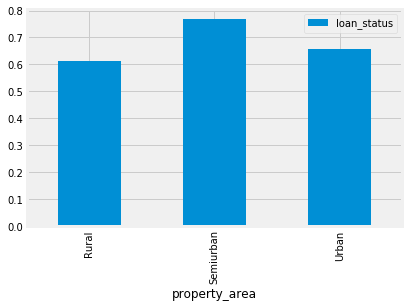

In [222]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Property Area')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Property Area')
proparea1.plot(kind='bar')

ax2 = fig.add_subplot(122)
proparea2.plot(kind = 'bar')
ax2.set_xlabel('Property Area')
ax2.set_ylabel('Probability of Getting Loan')
ax2.set_title('Probability of Getting Loan by Property Area')

In [223]:
gender1 = train['gender'].value_counts(ascending=True)
gender2 = train.pivot_table(values='loan_status', index=['gender'],
                            aggfunc=lambda x: x.map({'Y': 1, 'N': 0}).mean())

print('Frequency Table for Gender')
print(gender1)

print('\nProbability of Getting Loan for Each Gender Class:')
print(gender2)

Frequency Table for Gender
Female    112
Male      502
Name: gender, dtype: int64

Probability of Getting Loan for Each Gender Class:
        loan_status
gender             
Female     0.669643
Male       0.691235


Text(0.5, 1.0, 'Probability of Getting Loan by Gender')

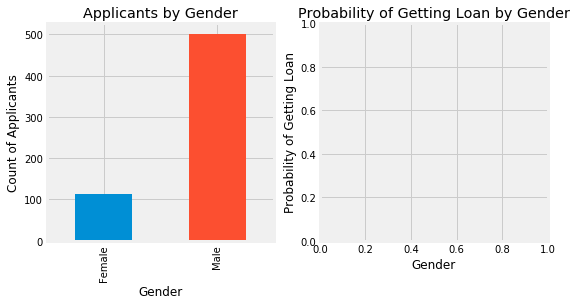

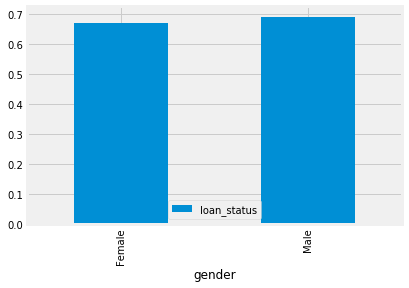

In [224]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Gender')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Gender')
gender1.plot(kind='bar')

ax2 = fig.add_subplot(122)
gender2.plot(kind='bar')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Probability of Getting Loan')
ax2.set_title('Probability of Getting Loan by Gender')

In [225]:
edu1 = train['education'].value_counts(ascending=True)
edu2 = train.pivot_table(values='loan_status', index=['education'],
                         aggfunc=lambda x: x.map({'Y': 1, 'N': 0}).mean())

print('Frequency Table for Education')
print(edu1)

print('\nProbability of Getting Loan for Each Education Class:')
print(edu2)

Frequency Table for Education
Not Graduate    134
Graduate        480
Name: education, dtype: int64

Probability of Getting Loan for Each Education Class:
              loan_status
education                
Graduate         0.708333
Not Graduate     0.611940


Text(0.5, 1.0, 'Probability of Getting Loan by Education')

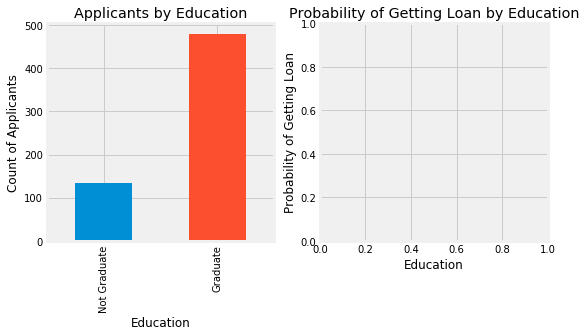

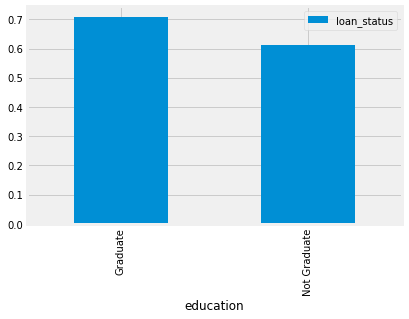

In [226]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Education')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Education')
edu1.plot(kind='bar')

ax2 = fig.add_subplot(122)
edu2.plot(kind='bar')
ax2.set_xlabel('Education')
ax2.set_ylabel('Probability of Getting Loan')
ax2.set_title('Probability of Getting Loan by Education')

## Model Fitting

**Since this is a classification problem, we can use classification models like a logistic regression, decision tree, random forest, etc.**

In [227]:
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']

X_test = test.drop('loan_id', axis=1)

In [228]:
# convert categorical variables into dummy variables
X_train_dummy = pd.get_dummies(X_train)
X_train_dummy.head()

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,loanamount_log,applicantincome_log,totalincome,totalincome_log,gender_Female,gender_Male,married_No,married_Yes,dependents_0,dependents_1,dependents_2,dependents_3+,education_Graduate,education_Not Graduate,self_employed_No,self_employed_Yes,property_area_Rural,property_area_Semiurban,property_area_Urban
0,5849,0.0,130.0,360.0,1.0,4.867534,8.674026,5849.0,8.674026,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,4583,1508.0,128.0,360.0,1.0,4.852030,8.430109,6091.0,8.714568,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
2,3000,0.0,66.0,360.0,1.0,4.189655,8.006368,3000.0,8.006368,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1
3,2583,2358.0,120.0,360.0,1.0,4.787492,7.856707,4941.0,8.505323,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,6000,0.0,141.0,360.0,1.0,4.948760,8.699515,6000.0,8.699515,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1


In [229]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['gender','married','dependents','education','self_employed','property_area','loan_status']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
train.dtypes 

gender                   int64
married                  int64
dependents               int64
education                int64
self_employed            int64
applicantincome          int64
coapplicantincome      float64
loanamount             float64
loan_amount_term       float64
credit_history         float64
property_area            int64
loan_status              int64
loanamount_log         float64
applicantincome_log    float64
totalincome            float64
totalincome_log        float64
dtype: object

In [230]:
# import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   # for K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

# generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    # fit the model:
    model.fit(data[predictors],data[outcome])
  
    # make predictions on training set:
    predictions = model.predict(data[predictors])
  
    # print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    # perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        # filter training data
        train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    # record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    # fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

### Logistic regression

In [231]:
# standardize our data set
sc = StandardScaler()
sc.fit(X_train_dummy)
X_train_std = sc.transform(X_train_dummy)

# create logistic regression object
log_regr = LogisticRegression()

# fit classifier onto the train set
log_regr.fit(X_train_std, y_train)

# calculate training accuracy
print('Training accuracy score:', log_regr.score(X_train_std, y_train))

Training accuracy score: 0.8127035830618893


In [232]:
outcome_var = 'loan_status'
model = LogisticRegression()
predictor_var = ['credit_history']
classification_model(model, train, predictor_var, outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 81.967%


In [233]:
# we can try different combination of variables:
predictor_var = ['credit_history','education','married','self_employed','property_area']
classification_model(model, train, predictor_var, outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 81.967%


#### Logistic regression w/ L1 regularization

In [234]:
# create logistic regression object w/ l1 regularization
log_lasso = LogisticRegression(penalty='l1')

# fit classifier onto the train set
log_lasso.fit(X_train_std, y_train)

# calculate training accuracy
print('Training accuracy score:', log_lasso.score(X_train_std, y_train))

Training accuracy score: 0.8127035830618893


**Lasso regularization automatically performs model selection and assigns coefficients of some features to zero.**

#### Logistic regression w/ L2 regularization

In [235]:
# create logistic regression object w/ l2 regularization
log_ridge = LogisticRegression(penalty='l2')

# fit classifier onto train set
log_ridge.fit(X_train_std, y_train)

# calculate training accuracy
print('Training accuracy score:', log_ridge.score(X_train_std, y_train))

Training accuracy score: 0.8127035830618893


**Ridge regularization does not have a model selection function so all features are included. Coefficients reach close to zero but not absolute zero.**

### Decision tree

In [236]:
# create a tree object
tree_clf = DecisionTreeClassifier()

# fit classifier onto the train set
tree_clf.fit(X_train_dummy, y_train)

# calculate training accuracy
print('Training accuracy score:', tree_clf.score(X_train_dummy, y_train))

Training accuracy score: 1.0


In [237]:
model = DecisionTreeClassifier()
predictor_var = ['credit_history','gender','married','education']
classification_model(model, train, predictor_var, outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 81.967%


In [238]:
# we can try different combination of variables:
predictor_var = ['credit_history','loan_amount_term','loanamount_log']
classification_model(model, train, predictor_var, outcome_var)

Accuracy : 88.925%
Cross-Validation Score : 64.754%


**We know that decision trees tend to memorize the train set and have higher training accuracies. Therefore, the model tends to overfit and perform worse on the test set because of its inflexibility to generalize to other data that it has not seen before.**

### Random forest

In [239]:
# create a random forest object
rf_clf = RandomForestClassifier(criterion='gini')

# fit classifier onto the train set
rf_clf.fit(X_train_dummy, y_train)

# calculate training accuracy
print('Training accuracy score:', rf_clf.score(X_train_dummy, y_train))

Training accuracy score: 0.990228013029316


In [240]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['gender', 'married', 'dependents', 'education',
       'self_employed', 'loan_amount_term', 'credit_history', 'property_area',
        'loanamount_log','totalincome_log']
classification_model(model, train, predictor_var, outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 77.869%


### Feature Selection

In [241]:
# create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

credit_history      0.271646
totalincome_log     0.259092
loanamount_log      0.228781
dependents          0.055565
property_area       0.049832
loan_amount_term    0.042813
married             0.025138
education           0.023176
gender              0.022382
self_employed       0.021576
dtype: float64


In [242]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['totalincome_log','loanamount_log','credit_history','dependents','property_area']
classification_model(model, train, predictor_var, outcome_var)

Accuracy : 82.736%
Cross-Validation Score : 82.787%
